# Pretty Matplotlib Charts

The goal of this notebook is to capture the [LinkedIn Post](https://www.linkedin.com/feed/update/urn:li:activity:7206997957605249024/) and [Blog post/tutorial](https://python-graph-gallery.com/web-map-with-custom-legend/) from Yan Holtz on creating really good looking `matplotlib` maps.

The idea is that creating maps is a very iterative process that involves many steps to get to a publication ready map.

## My Map

For my map, I will be creating a max temp by county map using data from the National Weather Service (NWS). The data comes from NOWData - NOAA Online Weather Data. Each county's maximum temperature from the week of 6/16/24 - 6/22/2024 from a weather station in each county.

To keep the map looking really clean, I want to focus on counties in Southeast Michigan. This includes Huron, Tuscola, Sanilac, Genesee, Lapeer, St. Clair, Macomb, Oakland, Livingston, Ingham, Washtenaw, Wayne, Lenawee, and Monroe counties.

## Loading the Weather Data

For the first itration of the project, all data is manually gathered. This reflects the reality of how data is often gathered in the real world. It isn't ideal long term, but it happens, it gets projects going, and it gets results.

The data will be loaded into `pandas` data frames to make it easy to join to the geometry later for mapping.

In [38]:
import pandas as pd

temperatures = pd.DataFrame({
    'County': ['Huron', 'Tuscola', 'Sanilac', 'Genesee',
               'Lapeer', 'St. Clair', 'Macomb', 'Oakland',
               'Livingston', 'Ingham', 'Washtenaw', 'Wayne',
               'Lenawee', 'Monroe',],
    'Weather Station City': ['Bad Axe', 'Caro', 'Sandusky', 'Flint',
                             'Lapeer', 'Yale', 'Mt. Clemens', 'Pontiac',
                             'Howell', 'East Lansing', 'Chelsea', 'Detroit',
                             'Adrian', None,],
    'Max Temp': [92, 92, None, None,
                 92, None, None, 93,
                 None, None, 93, 96,
                 94, None,],
})

Again with real world data, sometimes you just don't have the values you are looking for. In this case, there wasn't historic data for a weather station from this source available for Monroe county. Other sites just didn't have any data available for June 2024.

It's worth looking into how to get this information from other sources to have a more complete data set to work with, but having missing data also gives us a more interesting challenge when mapping, how to make these look good while displaying the missing county data.

## Loading the Geographic data

To map this data, we're going to need to load the boundaries for the michigan counties that have been selected. These are readily available to be loaded directly from the state of Michigan's GIS portal. The geojson can be loaded directly from the endpoint.

To get the data from any ArcGIS based GIS portal, you can go to the about page for the layer. For example in [Counties (v17a)](https://gis-michigan.opendata.arcgis.com/datasets/67a8ff23b5f54f15b7133b8c30981441_0/about), in the **I want to...** section, there is a **View API Resources** menu. Copying the **GeoJSON** URL is what will allow us to load this layer into Python.

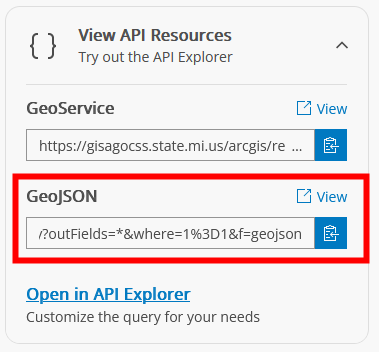

In [39]:
import geopandas as gpd

mi_counties_url = 'https://gisagocss.state.mi.us/arcgis/rest/services/OpenData/michigan_geographic_framework/MapServer/0/query?outFields=*&where=1%3D1&f=geojson'

county_boundaries = gpd.read_file(mi_counties_url)

There are a lot of extra columns that we don't really need in the county shape file. The main ones are the names and the geometry for the actual shape to plot it.

In [40]:
county_boundaries = county_boundaries[['NAME', 'LABEL', 'geometry']]
county_boundaries.head()

,NAME,LABEL,geometry
0,Alcona,Alcona County,"POLYGON ((-83.88712 44.55385, -83.88711 44.552..."
1,Alger,Alger County,"MULTIPOLYGON (((-87.11602 46.27726, -87.11600 ..."
2,Allegan,Allegan County,"POLYGON ((-85.54343 42.42905, -85.54343 42.430..."
3,Alpena,Alpena County,"MULTIPOLYGON (((-83.34340 44.88554, -83.34361 ..."
4,Antrim,Antrim County,"MULTIPOLYGON (((-84.84877 44.93222, -84.84878 ..."


## Filtering for My Counties

I'm just going to use a left join from my counties to the geographies. This will keep only the counties in my temperature data frame.

We have to convert the output back into a geodataframe because the pandas function doesn't keep the geodataframe intact.

In [41]:
data = pd.merge(temperatures, county_boundaries, left_on = 'County', right_on='NAME', how="left")

data = gpd.GeoDataFrame(data)

data.head()

,County,Weather Station City,Max Temp,NAME,LABEL,geometry
0,Huron,Bad Axe,92.0,Huron,Huron County,"MULTIPOLYGON (((-83.43124 43.78434, -83.43146 ..."
1,Tuscola,Caro,92.0,Tuscola,Tuscola County,"MULTIPOLYGON (((-83.20227 43.32525, -83.19996 ..."
2,Sanilac,Sandusky,NaN,Sanilac,Sanilac County,"MULTIPOLYGON (((-83.09949 43.28414, -83.09198 ..."
3,Genesee,Flint,NaN,Genesee,Genesee County,"POLYGON ((-83.92764 42.88285, -83.92756 42.880..."
4,Lapeer,Lapeer,92.0,Lapeer,Lapeer County,"POLYGON ((-82.98690 42.98969, -82.98707 42.993..."


## Plotting the Initial Map

Here we can quickly use the geopandas library to plot our map.

`matplotlib` allows us to create a figure that we can display all of our mapping commands to.

The `.plot()` method of a geodataframe does a quick and dirty plot of our geometries.

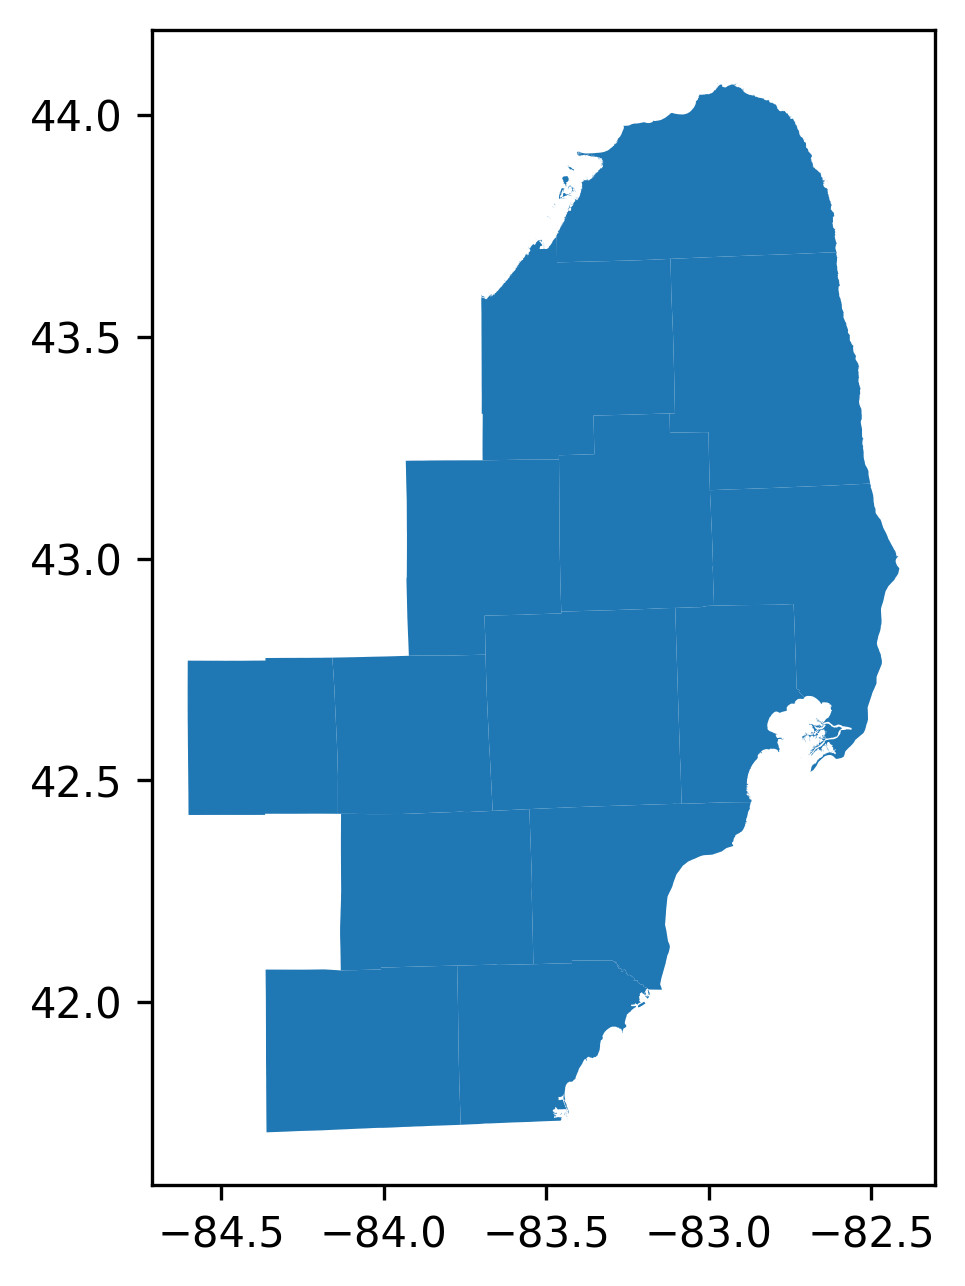

In [42]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5), dpi=300)

data.plot(ax=ax)
plt.show()

## Customizing the Axis (taking out the trash)

We don't really care about the longitude and latitude displayed in the axis. You either know where Michigan is at this point, or you aren't really going to find this tutorial that interesting anyway.

To get rid of them, we can use the `.set_axis_off()` method.

If there was some geometry that was really far away from our area of interest, we could use `.set_xlim()` and `.set_ylim()` to zero in on the part of our geometry that we actually care about.

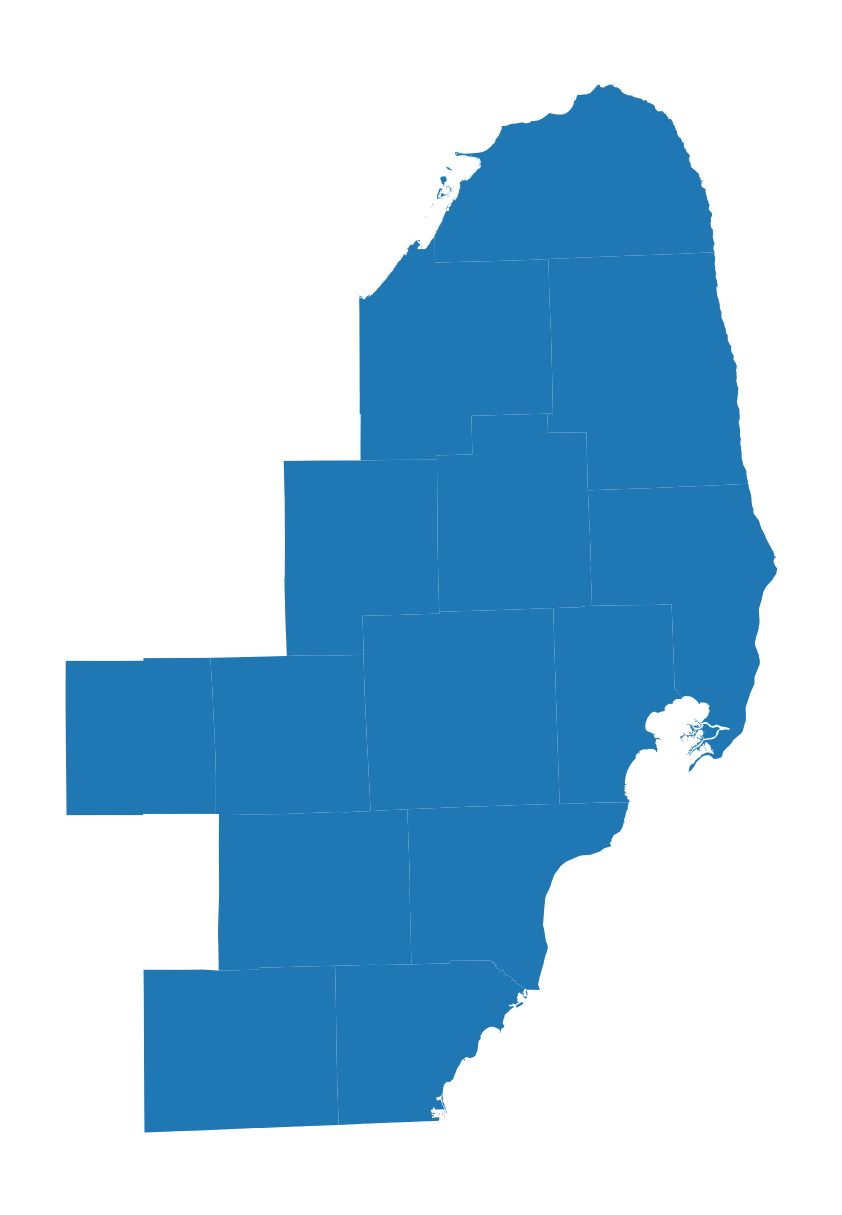

In [43]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=300)

data.plot(ax=ax)

ax.set_axis_off()

plt.show()

## Coloring the Map

Next we want to color the map. We are looking for a 🔥 hot color palette. Luckily, there is a handy tool called pypalettes that provides 2500+ curated color palettes to choose from. I'm going with the **OrYel** palette.

If you're looking for more palettes, check out https://python-graph-gallery.com/color-palette-finder/. It shows what different charts will look like in the selected color palette, along with having options to filter and sort the palettes and see how the appear to people with different color blindness (super helpful for testing accessibility on your maps!).

Load the `load_cmap` function from the `pypalettes` package.

Then, initiate the colormap.

The first layer of our map is the gray layer. Since we're missing some of the data for the counties, we can put this layer down first to cover the `Null` values that geopandas doesn't map.

Then we can map the actual data for the map. To get the color onto our map, use the `column` argument to specify the column that controls the color, and the `cmap` argument to add our colormap.

Other options can be set to increase the aestetics of the map, like the edgecolor of the counties, and the linewidth of the edge.

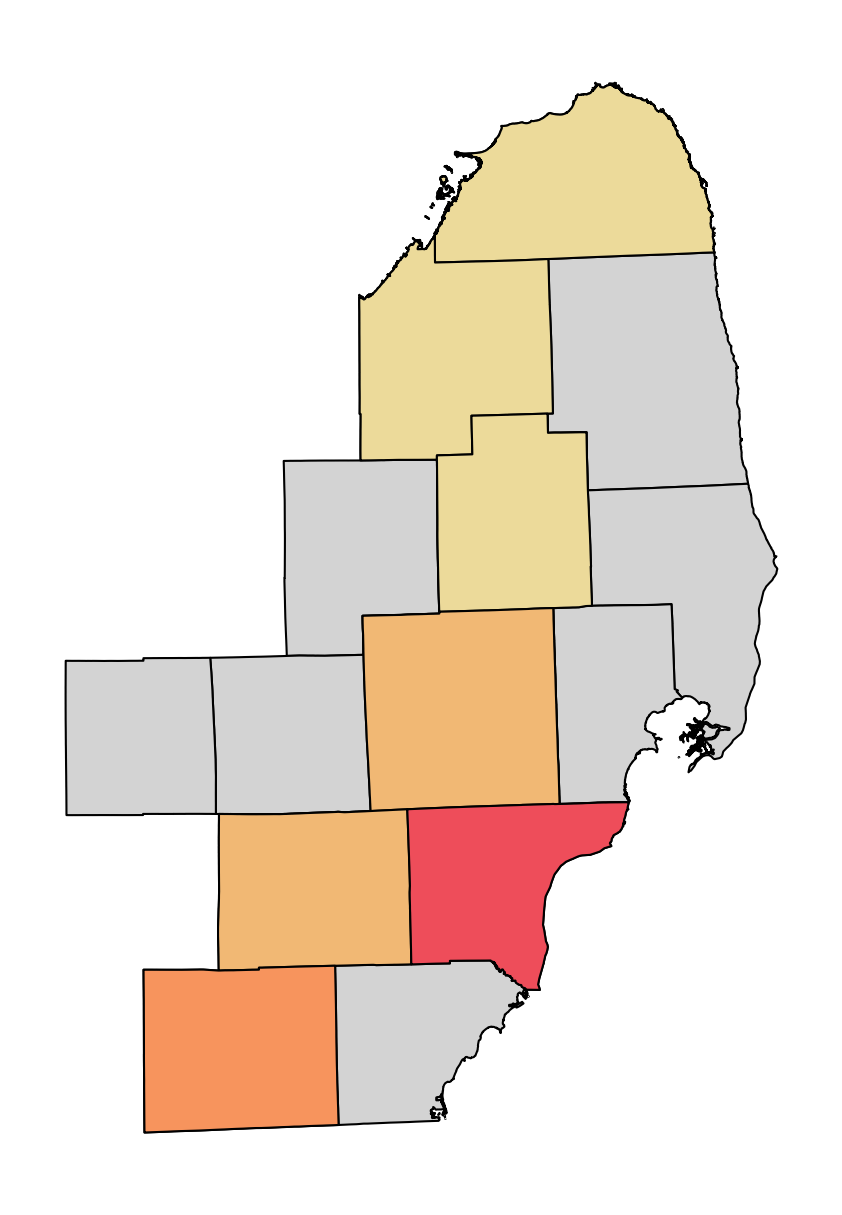

In [49]:
from pypalettes import load_cmap
import numpy as np

cmap = load_cmap('OrYel', type='continuous')

fig, ax = plt.subplots(figsize=(5, 5), dpi=300)

data.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.5)

data = data.fillna(np.nan)

data.plot(ax=ax, column='Max Temp', cmap=cmap, edgecolor='black', linewidth=0.5)

ax.set_axis_off()

plt.show()